c:\Users\Alice\miniconda3\envs\qiskit0.46\Lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


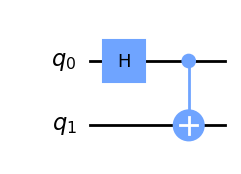

In [1]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

 
# Create a new circuit with two qubits
qc = QuantumCircuit(2)
 
# Add a Hadamard gate to qubit 0
qc.h(0)
 
# Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.cx(0, 1)
 
# Return a drawing of the circuit using MatPlotLib ("mpl"). This is the
# last line of the cell, so the drawing appears in the cell output.
# Remove the "mpl" argument to get a text drawing.
qc.draw("mpl")

In [2]:
from qiskit import Aer, QuantumCircuit, transpile, execute
from qiskit.circuit import Parameter
import numpy as np
from scipy.optimize import minimize

In [3]:
####d=1 layer####
# Step 1: Define the QCBM circuit
def qcbm_circuit(params, num_qubits):
    qc = QuantumCircuit(num_qubits)
    # Apply parameterized rotations and entangling gates
    idx = 0
    for q in range(num_qubits):
        qc.rz(params[idx], q)
        qc.rx(params[idx+1], q)
        qc.rz(params[idx+2], q)
        idx += 3
    for q in range(num_qubits - 1):
        qc.cx(q, q + 1)
    return qc

In [4]:
# Step 2: Define the loss function
def loss_function(params, num_qubits, target_distribution):
    # Generate the QCBM circuit
    qc = qcbm_circuit(params, num_qubits)
    qc.measure_all()
    
    # Simulate the circuit
    simulator = Aer.get_backend('qasm_simulator')
    qc = transpile(qc, simulator)
    result = execute(qc, backend=simulator, shots=1000).result()
    counts = result.get_counts()
    
    # Convert counts to probabilities
    generated_distribution = {k: v / 1000 for k, v in counts.items()}
    
    # Calculate KL divergence (or another metric) between target and generated distributions
    kl_divergence = 0
    for bitstring, target_prob in target_distribution.items():
        generated_prob = generated_distribution.get(bitstring, 1e-10)
        kl_divergence += target_prob * np.log(target_prob / generated_prob)
    
    return kl_divergence

In [5]:
# Step 3: Training the QCBM
num_qubits = 3
num_params = num_qubits * 3
initial_params = np.random.uniform(0, 2 * np.pi, num_params)

# Define target distribution (e.g., target state is |110⟩)
target_distribution = {'110': 0.8, '001': 0.2}

result = minimize(loss_function, initial_params, args=(num_qubits, target_distribution), method='COBYLA')

# Optimized parameters
optimized_params = result.x

C:\Users\Alice\AppData\Local\Temp\ipykernel_9396\1109074964.py:8: DeprecationWarning: The 'qiskit.Aer' entry point is deprecated and will be removed in Qiskit 1.0. You should use 'qiskit_aer.Aer' directly instead.
  simulator = Aer.get_backend('qasm_simulator')
C:\Users\Alice\AppData\Local\Temp\ipykernel_9396\1109074964.py:10: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  result = execute(qc, backend=simulator, shots=1000).result()


In [6]:
# Step 4: Generate samples using trained QCBM
trained_qcbm = qcbm_circuit(optimized_params, num_qubits)
trained_qcbm.measure_all()
fig = trained_qcbm.draw(output="mpl")
fig.savefig("qcbm_circuit.png", dpi = 500)

c:\Users\Alice\miniconda3\envs\qiskit0.46\Lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


In [7]:
simulator = Aer.get_backend('qasm_simulator')
trained_qcbm = transpile(trained_qcbm, simulator)
result = execute(trained_qcbm, backend=simulator, shots=1000).result()
counts = result.get_counts()

print("Generated Distribution:", counts)

Generated Distribution: {'001': 155, '000': 1, '010': 4, '110': 840}


In [8]:
###Gradient Descent###
from qiskit import Aer, QuantumCircuit, transpile, execute
from qiskit.circuit import Parameter
import numpy as np

def loss_function(params, num_qubits, target_distribution):
    qc = qcbm_circuit(params, num_qubits)
    qc.measure_all()

    simulator = Aer.get_backend('qasm_simulator')
    qc = transpile(qc, simulator)
    result = execute(qc, backend=simulator, shots=1000).result()
    counts = result.get_counts()

    # Normalize counts to probabilities
    generated_distribution = {k: v / 1000 for k, v in counts.items()}

    # Calculate KL divergence
    kl_divergence = 0
    for bitstring, target_prob in target_distribution.items():
        generated_prob = generated_distribution.get(bitstring, 1e-10)
        kl_divergence += target_prob * np.log(target_prob / generated_prob)

    return kl_divergence


In [9]:
def gradient_computer(params,params_shift,num_qubits, target_distribution):
    qc_a = qcbm_circuit(params, num_qubits)
    qc_a.measure_all()

    simulator = Aer.get_backend('qasm_simulator')
    qc_a = transpile(qc_a, simulator)
    result_a = execute(qc_a, backend=simulator, shots=1000).result()
    counts_a = result_a.get_counts()
    
    # Normalize counts to probabilities
    generated_distribution_a = {k: v / 1000 for k, v in counts_a.items()}
    
    qc_b = qcbm_circuit(params_shift, num_qubits)
    qc_b.measure_all()

    simulator = Aer.get_backend('qasm_simulator')
    qc_b = transpile(qc_b, simulator)
    result_b = execute(qc_b, backend=simulator, shots=1000).result()
    counts_b = result_b.get_counts()

    # Normalize counts to probabilities
    generated_distribution_b = {k: v / 1000 for k, v in counts_b.items()}
    
    gradient_component=0
    for bitstring, target_prob in target_distribution.items():
        generated_prob_a = generated_distribution_a.get(bitstring, 1e-10)
        generated_prob_b = generated_distribution_b.get(bitstring, 1e-10)
        gradient_component -=  target_prob /generated_prob_a*generated_prob_b
        
    return gradient_component

In [10]:
def compute_gradients(params, num_qubits, target_distribution):
    gradients = np.zeros_like(params)
    shift = np.pi / 2  # Parameter shift value

    for i in range(len(params)):
        # Shift parameter up
        params_shifted_up = np.copy(params)
        params_shifted_up[i] += shift
        loss_up = gradient_computer(params,params_shifted_up, num_qubits, target_distribution)

        # Shift parameter down
        params_shifted_down = np.copy(params)
        params_shifted_down[i] -= shift
        loss_down = gradient_computer(params, params_shifted_down, num_qubits, target_distribution)

        # Compute gradient
        gradients[i] = (loss_up - loss_down)

    return gradients


In [11]:
def gradient_descent(initial_params, num_qubits, target_distribution, learning_rate=0.1, max_iters=100):
    params = np.copy(initial_params)

    for iteration in range(max_iters):
        # Compute gradients
        gradients = compute_gradients(params, num_qubits, target_distribution)

        # Update parameters
        params -= learning_rate * gradients

        # Optional: Print progress
        loss = loss_function(params, num_qubits, target_distribution)
        print(f"Iteration {iteration + 1}: Loss = {loss}")
        if loss<0.1:
            break
    return params

In [12]:
# Define parameters
num_qubits = 3
num_params = num_qubits * 3
initial_params = np.random.uniform(0, 2 * np.pi, num_params)

# Define target distribution
target_distribution = {'110': 0.8, '001': 0.2}

# Train using gradient descent
optimized_params = gradient_descent(
    initial_params, 
    num_qubits, 
    target_distribution, 
    learning_rate=0.1, 
    max_iters=100
    
)

print("Optimized Parameters:", optimized_params)


Iteration 1: Loss = 5.5284630245094615
Iteration 2: Loss = 5.5284630245094615
Iteration 3: Loss = 8.343421655688333
Iteration 4: Loss = 5.119802525496668
Iteration 5: Loss = 5.298317366548036
Iteration 6: Loss = 5.078594908814415
Iteration 7: Loss = 5.389833588397472
Iteration 8: Loss = 4.649573193574974
Iteration 9: Loss = 3.545336862946234
Iteration 10: Loss = 4.167149054718433
Iteration 11: Loss = 4.216763933362731
Iteration 12: Loss = 3.509775452889567
Iteration 13: Loss = 3.47572776135453
Iteration 14: Loss = 3.705873419315955
Iteration 15: Loss = 3.2740712759875263
Iteration 16: Loss = 3.155185078644494
Iteration 17: Loss = 2.7437493779063935
Iteration 18: Loss = 2.5640073536316246
Iteration 19: Loss = 2.3860975066919483
Iteration 20: Loss = 2.252987374731781
Iteration 21: Loss = 2.0400773602141955
Iteration 22: Loss = 2.026110498862946
Iteration 23: Loss = 1.8476427757752052
Iteration 24: Loss = 1.5588577960774097
Iteration 25: Loss = 1.3392820519876703
Iteration 26: Loss = 1.20

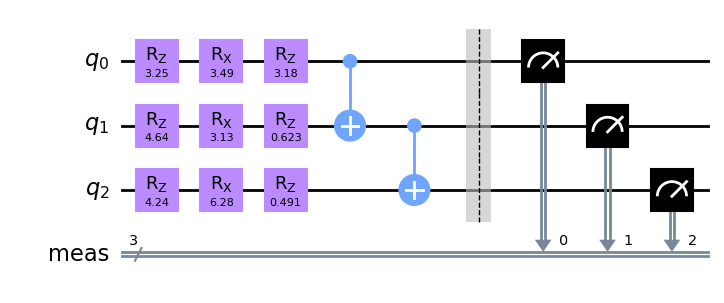

In [14]:
trained_qcbm_gd = qcbm_circuit(optimized_params, num_qubits)
trained_qcbm_gd.measure_all()
trained_qcbm_gd.draw(output="mpl")

In [15]:
result = execute(trained_qcbm, backend=simulator, shots=1000).result()
counts = result.get_counts()

print("Generated Distribution:", counts)

Generated Distribution: {'001': 174, '110': 826}
